# Baseline Model Classifier



## Pre-steps

### Importing packages

In [4]:
# Data Processing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from preprocessing import *


# model creation and evaluation
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

# pipeline/ encoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer, OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

### Loading and preprocessing data

#### Loading data

In [7]:
df_complete = pd.read_csv('../data/final_large_dataset_complete_15-06-2024.csv', low_memory=False)
df_0_900 = pd.read_csv('../data/final_large_dataset_0_900_15-06-2024.csv', low_memory=False)
df_900_2000 = pd.read_csv('../data/final_large_dataset_900_2000_15-06-2024.csv', low_memory=False)
df_2000_2500 = pd.read_csv('../data/final_large_dataset_2000_2500_15-06-2024.csv', low_memory=False)

,Unnamed: 0,TRAFFIC_DATE,TRAINNUMBER,TRAINSERIE,TRAINSERIE_DIRECTION,STATION,ACTIVITYTYPE,PLAN_DATETIME,REALIZED_DATETIME,DELAY,...,MAX_DEPARTURE_TIME,PLAN_SIGNAL_SAFE_DELAY,REALIZED_SIGNAL_SAFE_DELAY,DAY_IN_WEEK,24-TIME,DALUREN,NEEDED_PLAN_TURNOVER_TIME,NEEDED_REALIZED_TURNOVER_TIME,DIFF_TURNOVER_TIME,DIFF_TURNOVER_TIME_CAT
0,40,2023-03-06,519,500.0,O,Ut,V,2023-03-06 06:49:00+00:00,2023-03-06 06:49:38+00:00,38.0,...,2023-03-06 06:49:38+00:00,-53.0,-91.0,0,2024-05-15 06:49:00,False,442.0,468.0,-26.0,perfect
1,78,2023-03-06,523,500.0,O,Ut,V,2023-03-06 07:49:00+00:00,2023-03-06 07:48:58+00:00,-2.0,...,2023-03-06 07:48:58+00:00,-52.0,-50.0,0,2024-05-15 07:49:00,False,482.0,425.0,57.0,perfect
2,94,2023-03-06,524,500.0,E,Ut,V,2023-03-06 09:18:00+00:00,2023-03-06 09:18:04+00:00,4.0,...,2023-03-06 09:18:04+00:00,-53.0,-57.0,0,2024-05-15 09:18:00,True,476.0,440.0,36.0,perfect
3,106,2023-03-06,527,500.0,O,Ut,V,2023-03-06 08:49:00+00:00,2023-03-06 08:49:15+00:00,15.0,...,2023-03-06 08:49:15+00:00,-53.0,-68.0,0,2024-05-15 08:49:00,False,465.0,464.0,1.0,perfect
4,134,2023-03-06,531,500.0,O,Ut,V,2023-03-06 09:49:00+00:00,2023-03-06 09:49:11+00:00,11.0,...,2023-03-06 09:49:11+00:00,-53.0,-64.0,0,2024-05-15 09:49:00,True,469.0,522.0,-53.0,perfect


#### Encoding data

In [8]:
# for minimal features use
# numerical features
numerical_minimal_features = ['NUMBER_CARRIAGES', 
          # 'NEEDED_PLAN_TURNOVER_TIME', 
          'NEEDED_REALIZED_TURNOVER_TIME'
                              ]
numeric_transformer = Pipeline(
  steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)
# nominal features
nominal_minimal_features = ['DAY_IN_WEEK', 'TRAINSERIE','STATION', 'COMBINE', 'SPLIT', 'ROLLINGSTOCK_TYPE', 'DALUREN', 'DRIVER_CHANGE']
nominal_transformer = Pipeline(
  steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ("selector", SelectPercentile(chi2, percentile=50)),
  ]
)

# preprocessing pipeline for encoding
preprocessor = ColumnTransformer(
  transformers=[
    ("numeric", numeric_transformer, numerical_minimal_features),
    ("nominal", nominal_transformer, nominal_minimal_features),
  ]
)



### Feature selection

In [9]:
# selecting features
target_feature = ['DIFF_TURNOVER_TIME_CAT']

final_numeric_features = ['NUMBER_CARRIAGES', 'PLAN_TURNOVER_TIME','HOUR_sin',	'HOUR_cos', 'DAY_OF_WEEK_sin',	'DAY_OF_WEEK_cos']

final_nominal_features = ['TRAINSERIE','STATION', 'COMBINE', 'SPLIT', 'ROLLINGSTOCK_TYPE', 'DALUREN', 'DRIVER_CHANGE', ]

### single decision tree function for results

In [10]:
def single_decision_result(df, numeric_features, nominal_features):
  this_df = df.copy()

  # all_features = nominal_features + numeric_features
  target_feature = "DIFF_TURNOVER_TIME_CAT"

  # # # split into X-feature and Y-target datasets
  # x = this_df[all_features]
  # y = this_df[target_feature]

  temp_nominal_data = this_df[nominal_features].apply(LabelEncoder().fit_transform)
  temp_nominal_data.columns = nominal_features

  temp_numeric_data = this_df[numeric_features]
  temp_numeric_data.columns = numeric_features


  temp_final = pd.concat([temp_nominal_data, temp_numeric_data], axis=1, ignore_index=True)
  use_features = (nominal_features + numeric_features)
  temp_final.columns = use_features

  forest_model = DecisionTreeClassifier()

  # split into X-feature and Y-target datasets
  x = temp_final[use_features]
  y = this_df[target_feature]


  # split train test data
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2)
  # 80% train, 20% test is generally recommended

  forest_model.fit(x_train, y_train)

  # make predictions on the test set
  y_pred_best_param_forest_classifier = forest_model.predict(x_test)

  # evaluate the model
  classification_best_param_forest_classifier = classification_report(y_test, y_pred_best_param_forest_classifier)
  print(f"Classification Report:\n {classification_best_param_forest_classifier}")

  # Model Accuracy: how often is the classifier correct?
  accuracy_best_param_forest_classifier = accuracy_score(y_test, y_pred_best_param_forest_classifier)
  # Model Precision: what percentage of positive tuples are labeled as such?
  precision_best_param_forest_classifier = precision_score(y_test, y_pred_best_param_forest_classifier, average='weighted')
  # Model Recall: what percentage of positive tuples are labelled as such?
  recall_best_param_forest_classifier = recall_score(y_test, y_pred_best_param_forest_classifier, average='weighted')
  # Model f1: 
  f1_best_param_forest_classifier = f1_score(y_test, y_pred_best_param_forest_classifier, average='weighted')

  # printout
  print(f"""Results rbf SVC:
  Accuracy: {accuracy_best_param_forest_classifier}
  Precision: {precision_best_param_forest_classifier}
  Recall: {recall_best_param_forest_classifier}
  F1 score: {f1_best_param_forest_classifier}""")

  # Model confusion matrix: 
  confmat_best_param_forest_classifier = confusion_matrix(y_test, y_pred_best_param_forest_classifier, labels = ['too early', 'perfect', 'too late'], normalize='pred')
  # normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
  cm_display_best_param_forest_classifier = ConfusionMatrixDisplay(confmat_best_param_forest_classifier, display_labels=['too early', 'perfect', 'too late'])

  cm_display_best_param_forest_classifier.plot()
  plt.show()

,TRAINSERIE,STATION,COMBINE,SPLIT,ROLLINGSTOCK_TYPE,NUMBER_CARRIAGES,DRIVER_CHANGE,NEEDED_REALIZED_TURNOVER_TIME,DAY_IN_WEEK,DALUREN
936,600.0,Ut,0,0,DDZ,4.0,1.0,509.0,4,True
1632,1600.0,Es,0,0,DDZ,4.0,1.0,1977.0,0,True
2048,3900.0,Hrl,0,0,VIRM,4.0,1.0,448.0,0,True
9944,2400.0,Ddr,0,0,VIRM,6.0,1.0,512.0,4,True
457,500.0,Ut,0,0,DDZ,4.0,1.0,437.0,2,True


## Dummy Classifiers

### single tree classifier

Classification Report:
               precision    recall  f1-score   support

     perfect       0.79      0.90      0.84     36752
   too early       0.26      0.14      0.19      3927
    too late       0.27      0.14      0.19      6677

    accuracy                           0.73     47356
   macro avg       0.44      0.40      0.41     47356
weighted avg       0.68      0.73      0.70     47356

Results rbf SVC:
    Accuracy: 0.7302981670749219
    Precision: 0.6756643764752586
    Recall: 0.7302981670749219
    F1 score: 0.6960794915998646


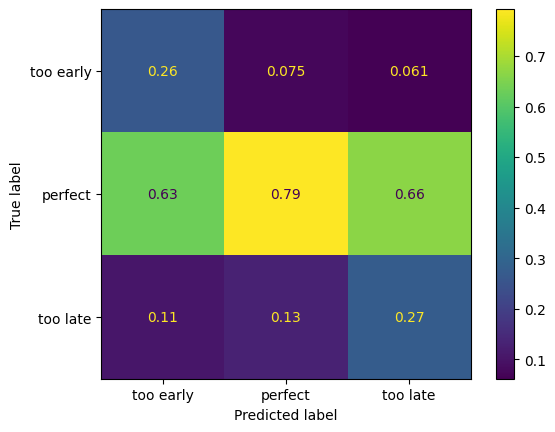

Classification Report:
               precision    recall  f1-score   support

     perfect       0.79      0.91      0.85     19807
   too early       0.21      0.11      0.15      1864
    too late       0.45      0.24      0.32      4343

    accuracy                           0.74     26014
   macro avg       0.48      0.42      0.44     26014
weighted avg       0.69      0.74      0.71     26014

Results rbf SVC:
    Accuracy: 0.7383332051972015
    Precision: 0.6926053289243389
    Recall: 0.7383332051972015
    F1 score: 0.7065988262252325


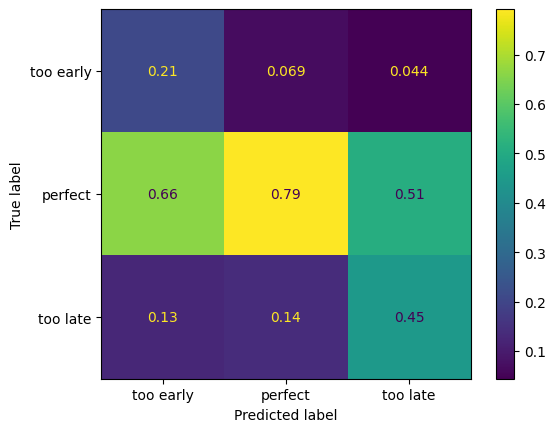

Classification Report:
               precision    recall  f1-score   support

     perfect       0.82      0.91      0.86     14665
   too early       0.33      0.20      0.25      1752
    too late       0.35      0.20      0.26      2078

    accuracy                           0.76     18495
   macro avg       0.50      0.44      0.46     18495
weighted avg       0.72      0.76      0.74     18495

Results rbf SVC:
    Accuracy: 0.7611246282779129
    Precision: 0.7210671468998232
    Recall: 0.7611246282779129
    F1 score: 0.7358109030211142


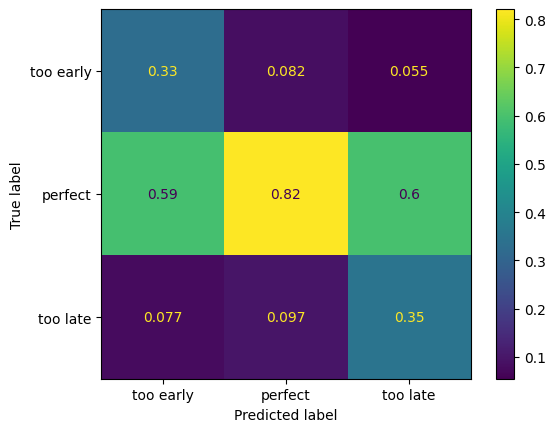

Classification Report:
               precision    recall  f1-score   support

     perfect       0.80      0.89      0.84      2226
   too early       0.28      0.18      0.22       282
    too late       0.28      0.16      0.20       340

    accuracy                           0.73      2848
   macro avg       0.45      0.41      0.42      2848
weighted avg       0.68      0.73      0.70      2848

Results rbf SVC:
    Accuracy: 0.730688202247191
    Precision: 0.6844097393707814
    Recall: 0.730688202247191
    F1 score: 0.7022476372771327


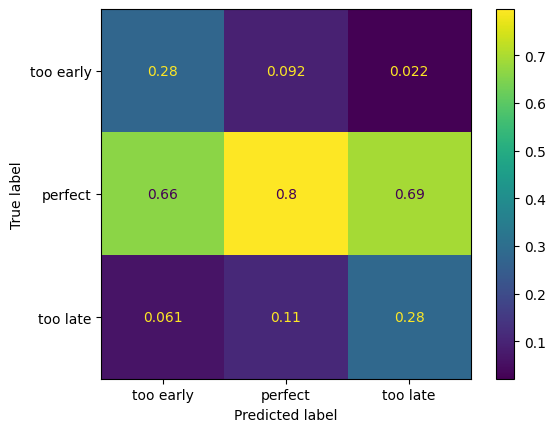

In [5]:
single_decision_result(df_complete, final_numeric_features, final_nominal_features)
single_decision_result(df_0_900, final_numeric_features, final_nominal_features)
single_decision_result(df_900_2000, final_numeric_features, final_nominal_features)
single_decision_result(df_2000_2500, final_numeric_features, final_nominal_features)

### Most frequent stategy

*Most Frequent*: The classifier always predicts the most frequent class label in the training data.

Classification Report:
               precision    recall  f1-score   support

     perfect       0.78      1.00      0.87      2351
   too early       0.00      0.00      0.00       260
    too late       0.00      0.00      0.00       413

    accuracy                           0.78      3024
   macro avg       0.26      0.33      0.29      3024
weighted avg       0.60      0.78      0.68      3024

Results rbf SVC:
  Accuracy: 0.77744708994709
  Precision: 0.6044239776671986
  Recall: 0.77744708994709
  F1 score: 0.6801034822197612


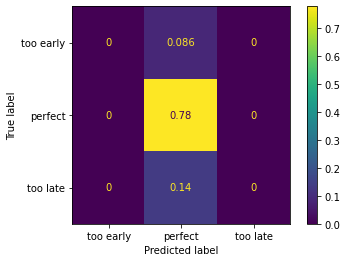

In [18]:
# train the model 
dummy_most_frequent = Pipeline(
  steps=[
    ("preprocessor", preprocessor),
    ("dummy_most_frequent", DummyClassifier(
      strategy='most_frequent', random_state=42)
      ),
  ]
)

dummy_most_frequent.fit(x_train, y_train)

# make predictions on the test set
y_pred_dummy_most_frequent = dummy_most_frequent.predict(x_test)

# evaluate the model
classification_dummy_most_frequent = classification_report(y_test, y_pred_dummy_most_frequent)
print(f"Classification Report:\n {classification_dummy_most_frequent}")

# Model Accuracy: how often is the classifier correct?
accuracy_dummy_most_frequent = accuracy_score(y_test, y_pred_dummy_most_frequent)
# Model Precision: what percentage of positive tuples are labeled as such?
precision_dummy_most_frequent = precision_score(y_test, y_pred_dummy_most_frequent, average='weighted')
# Model Recall: what percentage of positive tuples are labelled as such?
recall_dummy_most_frequent = recall_score(y_test, y_pred_dummy_most_frequent, average='weighted')
# Model f1: 
f1_dummy_most_frequent = f1_score(y_test, y_pred_dummy_most_frequent, average='weighted')

# printout
print(f"""Results rbf SVC:
  Accuracy: {accuracy_dummy_most_frequent}
  Precision: {precision_dummy_most_frequent}
  Recall: {recall_dummy_most_frequent}
  F1 score: {f1_dummy_most_frequent}""")

# Model confusion matrix: 
confmat_dummy_most_frequent = confusion_matrix(y_test, y_pred_dummy_most_frequent, labels = ['too early', 'perfect', 'too late'], normalize='pred')
# normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
cm_display_dummy_most_frequent = ConfusionMatrixDisplay(confmat_dummy_most_frequent, display_labels=['too early', 'perfect', 'too late'])

cm_display_dummy_most_frequent.plot()
plt.show()

### Stratified strategy

*Stratified*: It generates predictions by respecting the class distribution of the training data. It is different from the “most frequent” strategy as it instead associates a probability with each data point of being the most frequent class label.

Classification Report:
               precision    recall  f1-score   support

     perfect       0.78      0.79      0.79      2351
   too early       0.10      0.10      0.10       260
    too late       0.14      0.13      0.13       413

    accuracy                           0.64      3024
   macro avg       0.34      0.34      0.34      3024
weighted avg       0.64      0.64      0.64      3024

Results rbf SVC:
  Accuracy: 0.6415343915343915
  Precision: 0.6368398277755518
  Recall: 0.6415343915343915
  F1 score: 0.6391600920273971


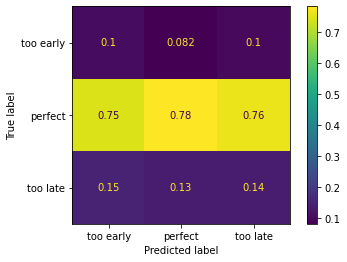

In [19]:
# train the model 
dummy_stratified = Pipeline(
  steps=[
    ("preprocessor", preprocessor),
    ("dummy_stratified", DummyClassifier(
      strategy='stratified', random_state=42)
      ),
  ]
)

dummy_stratified.fit(x_train, y_train)

# make predictions on the test set
y_pred_dummy_stratified = dummy_stratified.predict(x_test)

# evaluate the model
classification_dummy_stratified = classification_report(y_test, y_pred_dummy_stratified)
print(f"Classification Report:\n {classification_dummy_stratified}")

# Model Accuracy: how often is the classifier correct?
accuracy_dummy_stratified = accuracy_score(y_test, y_pred_dummy_stratified)
# Model Precision: what percentage of positive tuples are labeled as such?
precision_dummy_stratified = precision_score(y_test, y_pred_dummy_stratified, average='weighted')
# Model Recall: what percentage of positive tuples are labelled as such?
recall_dummy_stratified = recall_score(y_test, y_pred_dummy_stratified, average='weighted')
# Model f1: 
f1_dummy_stratified = f1_score(y_test, y_pred_dummy_stratified, average='weighted')

# printout
print(f"""Results rbf SVC:
  Accuracy: {accuracy_dummy_stratified}
  Precision: {precision_dummy_stratified}
  Recall: {recall_dummy_stratified}
  F1 score: {f1_dummy_stratified}""")

# Model confusion matrix: 
confmat_dummy_stratified = confusion_matrix(y_test, y_pred_dummy_stratified, labels = ['too early', 'perfect', 'too late'], normalize='pred')
# normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
cm_display_dummy_stratified = ConfusionMatrixDisplay(confmat_dummy_stratified, display_labels=['too early', 'perfect', 'too late'])

cm_display_dummy_stratified.plot()
plt.show()

### Uniform stategy

*Uniform*: It generates predictions uniformly at random.

Classification Report:
               precision    recall  f1-score   support

     perfect       0.77      0.34      0.48      2351
   too early       0.09      0.33      0.14       260
    too late       0.14      0.32      0.19       413

    accuracy                           0.34      3024
   macro avg       0.33      0.33      0.27      3024
weighted avg       0.63      0.34      0.41      3024

Results rbf SVC:
  Accuracy: 0.3392857142857143
  Precision: 0.6281937029048007
  Recall: 0.3392857142857143
  F1 score: 0.40787024558582524


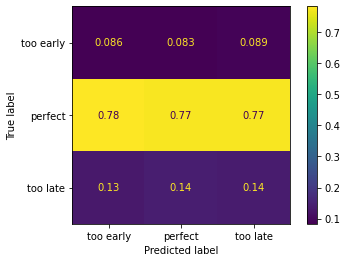

In [20]:
# train the model 
dummy_uniform = Pipeline(
  steps=[
    ("preprocessor", preprocessor),
    ("dummy_uniform", DummyClassifier(
      strategy='uniform', random_state=42)
      ),
  ]
)

dummy_uniform.fit(x_train, y_train)

# make predictions on the test set
y_pred_dummy_uniform = dummy_uniform.predict(x_test)

# evaluate the model
classification_dummy_uniform = classification_report(y_test, y_pred_dummy_uniform)
print(f"Classification Report:\n {classification_dummy_uniform}")

# Model Accuracy: how often is the classifier correct?
accuracy_dummy_uniform = accuracy_score(y_test, y_pred_dummy_uniform)
# Model Precision: what percentage of positive tuples are labeled as such?
precision_dummy_uniform = precision_score(y_test, y_pred_dummy_uniform, average='weighted')
# Model Recall: what percentage of positive tuples are labelled as such?
recall_dummy_uniform = recall_score(y_test, y_pred_dummy_uniform, average='weighted')
# Model f1: 
f1_dummy_uniform = f1_score(y_test, y_pred_dummy_uniform, average='weighted')

# printout
print(f"""Results rbf SVC:
  Accuracy: {accuracy_dummy_uniform}
  Precision: {precision_dummy_uniform}
  Recall: {recall_dummy_uniform}
  F1 score: {f1_dummy_uniform}""")

# Model confusion matrix: 
confmat_dummy_uniform = confusion_matrix(y_test, y_pred_dummy_uniform, labels = ['too early', 'perfect', 'too late'], normalize='pred')
# normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
cm_display_dummy_uniform = ConfusionMatrixDisplay(confmat_dummy_uniform, display_labels=['too early', 'perfect', 'too late'])

cm_display_dummy_uniform.plot()
plt.show()

### Constant strategy

*Constant*: The classifier always predicts a constant label and is primarily used when classifying non-majority class labels.

#### Constant = 'too early'

Classification Report:
               precision    recall  f1-score   support

     perfect       0.00      0.00      0.00      2351
   too early       0.09      1.00      0.16       260
    too late       0.00      0.00      0.00       413

    accuracy                           0.09      3024
   macro avg       0.03      0.33      0.05      3024
weighted avg       0.01      0.09      0.01      3024

Results rbf SVC:
  Accuracy: 0.08597883597883597
  Precision: 0.00739236023627558
  Recall: 0.08597883597883597
  F1 score: 0.013614188401033712


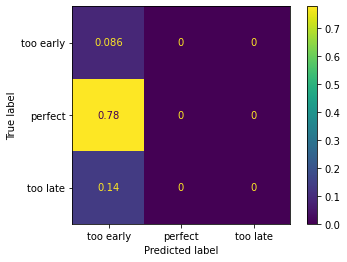

In [21]:
# train the model 
dummy_constant = Pipeline(
  steps=[
    ("preprocessor", preprocessor),
    ("dummy_constant", DummyClassifier(
      strategy='constant', random_state=42, constant = 'too early')
      ),
  ]
)

dummy_constant.fit(x_train, y_train)

# make predictions on the test set
y_pred_dummy_constant = dummy_constant.predict(x_test)

# evaluate the model
classification_dummy_constant = classification_report(y_test, y_pred_dummy_constant)
print(f"Classification Report:\n {classification_dummy_constant}")

# Model Accuracy: how often is the classifier correct?
accuracy_dummy_constant = accuracy_score(y_test, y_pred_dummy_constant)
# Model Precision: what percentage of positive tuples are labeled as such?
precision_dummy_constant = precision_score(y_test, y_pred_dummy_constant, average='weighted')
# Model Recall: what percentage of positive tuples are labelled as such?
recall_dummy_constant = recall_score(y_test, y_pred_dummy_constant, average='weighted')
# Model f1: 
f1_dummy_constant = f1_score(y_test, y_pred_dummy_constant, average='weighted')

# printout
print(f"""Results rbf SVC:
  Accuracy: {accuracy_dummy_constant}
  Precision: {precision_dummy_constant}
  Recall: {recall_dummy_constant}
  F1 score: {f1_dummy_constant}""")

# Model confusion matrix: 
confmat_dummy_constant = confusion_matrix(y_test, y_pred_dummy_constant, labels = ['too early', 'perfect', 'too late'], normalize='pred')
# normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
cm_display_dummy_constant = ConfusionMatrixDisplay(confmat_dummy_constant, display_labels=['too early', 'perfect', 'too late'])

cm_display_dummy_constant.plot()
plt.show()

#### Constant = 'too late'

Classification Report:
               precision    recall  f1-score   support

     perfect       0.00      0.00      0.00      2351
   too early       0.00      0.00      0.00       260
    too late       0.14      1.00      0.24       413

    accuracy                           0.14      3024
   macro avg       0.05      0.33      0.08      3024
weighted avg       0.02      0.14      0.03      3024

Results rbf SVC:
  Accuracy: 0.13657407407407407
  Precision: 0.018652477709190672
  Recall: 0.13657407407407407
  F1 score: 0.03282228256770009


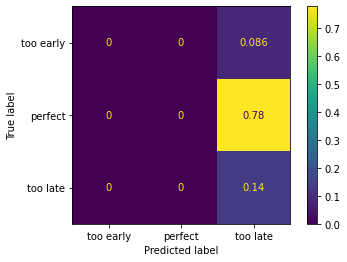

In [22]:
# train the model 
dummy_constant = Pipeline(
  steps=[
    ("preprocessor", preprocessor),
    ("dummy_constant", DummyClassifier(
      strategy='constant', random_state=42, constant = 'too late')
      ),
  ]
)

dummy_constant.fit(x_train, y_train)

# make predictions on the test set
y_pred_dummy_constant = dummy_constant.predict(x_test)

# evaluate the model
classification_dummy_constant = classification_report(y_test, y_pred_dummy_constant)
print(f"Classification Report:\n {classification_dummy_constant}")

# Model Accuracy: how often is the classifier correct?
accuracy_dummy_constant = accuracy_score(y_test, y_pred_dummy_constant)
# Model Precision: what percentage of positive tuples are labeled as such?
precision_dummy_constant = precision_score(y_test, y_pred_dummy_constant, average='weighted')
# Model Recall: what percentage of positive tuples are labelled as such?
recall_dummy_constant = recall_score(y_test, y_pred_dummy_constant, average='weighted')
# Model f1: 
f1_dummy_constant = f1_score(y_test, y_pred_dummy_constant, average='weighted')

# printout
print(f"""Results rbf SVC:
  Accuracy: {accuracy_dummy_constant}
  Precision: {precision_dummy_constant}
  Recall: {recall_dummy_constant}
  F1 score: {f1_dummy_constant}""")

# Model confusion matrix: 
confmat_dummy_constant = confusion_matrix(y_test, y_pred_dummy_constant, labels = ['too early', 'perfect', 'too late'], normalize='pred')
# normalize over predicted conditions calculates the part per class/ column, so if we sum over the columns we get 1. So this shows best for the model how it performs per class
cm_display_dummy_constant = ConfusionMatrixDisplay(confmat_dummy_constant, display_labels=['too early', 'perfect', 'too late'])

cm_display_dummy_constant.plot()
plt.show()